In [12]:
import numpy as np
import tensorflow as tf
from edward.models import Normal
import edward as ed

import seaborn as sn

import matplotlib.pyplot as plt
import os  

In [2]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

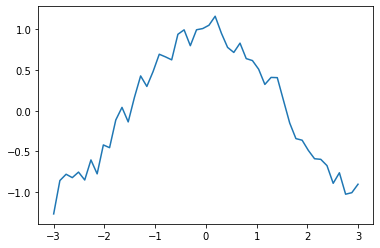

In [5]:
plt.plot(x_train, y_train)

In [6]:
W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [8]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [9]:
import edward as ed

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000)

/opt/python/dev/Anaconda2-5.0.1/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: -5.512


In [28]:

qW_0.eval(),qW_1.eval(),qb_0.eval(),qb_1.eval()

(array([[ 1.3066691, -1.2996515]], dtype=float32), array([[0.97389877],
        [0.99697757]], dtype=float32), array([2.0185359, 2.0524228], dtype=float32), array([-1.0152816], dtype=float32))

In [20]:
#y.sample().eval()

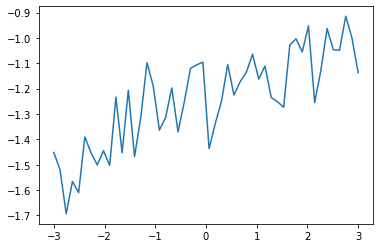

In [29]:
plt.plot(x_train,y.sample().eval() )

In [30]:
def build_toy_dataset(N, w, noise_std=0.1):
    D = len(w)
    x = np.random.randn(N, D)
    y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
    return x, y


In [32]:
N=10
D = 40
true_w =  np.random.randn(N)


(array([[ 0.5774461 ],
        [-1.87200702],
        [ 0.50263623],
        [-0.19398706],
        [-0.57246248],
        [ 1.35796805],
        [-1.08364919],
        [ 0.58485249],
        [ 0.257906  ],
        [ 1.18036517]]),
 array([ 1.23487434, -3.72695051,  1.11549044, -0.3097609 , -1.20900675,
         2.72887472, -2.06933345,  0.99491245,  0.41855679,  2.19114665]))

In [161]:
tf.reset_default_graph()

In [5]:
M = 128  # batch size during training
d = 100  # latent dimension

data_dir = "/tmp/data"
out_dir = "/tmp"

In [6]:
from observations import mnist

def generator(array, batch_size):
    """Generate batch with respect to array's first axis."""
    start = 0  # pointer to where we are in iteration
    while True:
        stop = start + batch_size
        diff = stop - array.shape[0]
        if diff <= 0:
            batch = array[start:stop]
            start += batch_size
        else:
            batch = np.concatenate((array[start:], array[:diff]))
            start = diff
        batch = batch.astype(np.float32) / 255.0  # normalize pixel intensities
        batch = np.random.binomial(1, batch)  # binarize images
        yield batch

data_dir = 'temp0/dev/anjani/'
(x_train, _), (x_test, _) = mnist(data_dir)
x_train_generator = generator(x_train, M)
x_ph = tf.placeholder(tf.float32, [M, 784])


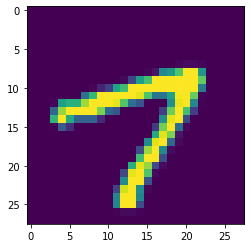

In [7]:
plt.imshow(x_train[101].reshape(28,28))

In [8]:
from edward.models import Uniform

def generative_network(eps):
    net = tf.layers.dense(eps, 128, activation=tf.nn.relu)
    net = tf.layers.dense(net, 784, activation=tf.sigmoid)
    return net

with tf.variable_scope("Gen"):
    eps = Uniform(tf.zeros([M, d]) - 1.0, tf.ones([M, d]))
    x = generative_network(eps)

In [9]:
def discriminative_network(x):
    """Outputs probability in logits."""
    net = tf.layers.dense(x, 128, activation=tf.nn.relu)
    net = tf.layers.dense(net, 1, activation=None)
    return net

In [22]:
inference = ed.GANInference(    data={x: x_ph}, discriminator=discriminative_network)

In [23]:
optimizer = tf.train.AdamOptimizer()
optimizer_d = tf.train.AdamOptimizer()

inference.initialize(    optimizer=optimizer, optimizer_d=optimizer_d,    n_iter=45000, n_print=1000)

ValueError: Variable Disc/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-9-2ae5e1b49e35>", line 3, in discriminative_network
    net = tf.layers.dense(x, 128, activation=tf.nn.relu)
  File "/opt/python/dev/Anaconda2-5.0.1/lib/python3.6/site-packages/edward/inferences/gan_inference.py", line 120, in build_loss_and_gradients
    d_true = self.discriminator(x_true)
  File "/opt/python/dev/Anaconda2-5.0.1/lib/python3.6/site-packages/edward/inferences/gan_inference.py", line 99, in initialize
    self.build_loss_and_gradients(var_list)


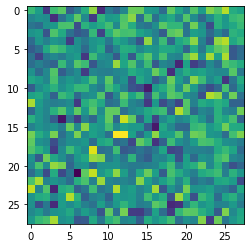

 1000/15000 [  6%] ██                             ETA: 7892s | Gen Loss: 5.406 | Disc Loss: 0.061   

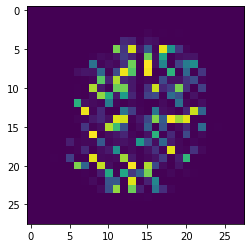

 2000/15000 [ 13%] ████                           ETA: 3702s | Gen Loss: 5.422 | Disc Loss: 0.038

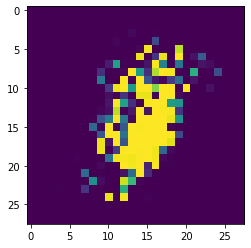

 3000/15000 [ 20%] ██████                         ETA: 2302s | Gen Loss: 4.443 | Disc Loss: 0.131

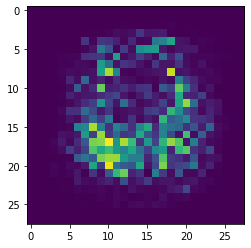

 4000/15000 [ 26%] ████████                       ETA: 1598s | Gen Loss: 5.644 | Disc Loss: 0.261

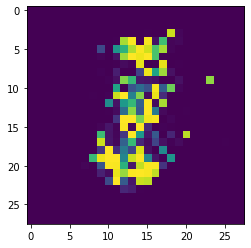

 5000/15000 [ 33%] ██████████                     ETA: 1173s | Gen Loss: 6.737 | Disc Loss: 0.210

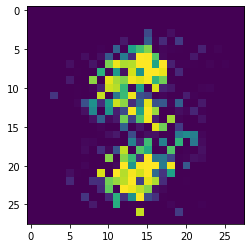

 6000/15000 [ 40%] ████████████                   ETA: 888s | Gen Loss: 6.958 | Disc Loss: 0.219 

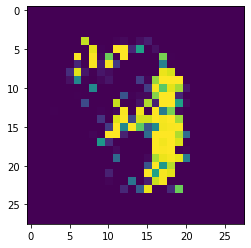

 7000/15000 [ 46%] ██████████████                 ETA: 683s | Gen Loss: 5.194 | Disc Loss: 0.466

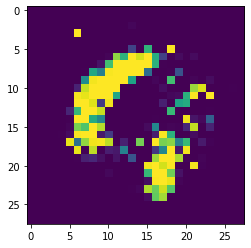

 8000/15000 [ 53%] ████████████████               ETA: 528s | Gen Loss: 6.297 | Disc Loss: 0.284

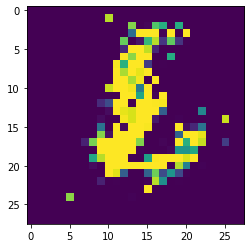

 9000/15000 [ 60%] ██████████████████             ETA: 407s | Gen Loss: 5.887 | Disc Loss: 0.268

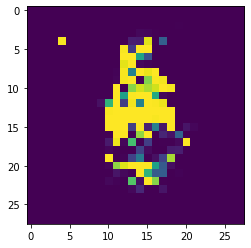

10000/15000 [ 66%] ████████████████████           ETA: 308s | Gen Loss: 3.587 | Disc Loss: 0.377

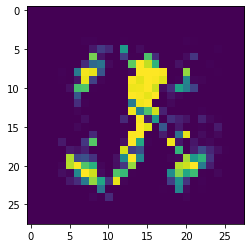

11000/15000 [ 73%] ██████████████████████         ETA: 226s | Gen Loss: 3.655 | Disc Loss: 0.617

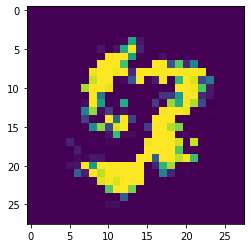

12000/15000 [ 80%] ████████████████████████       ETA: 157s | Gen Loss: 3.750 | Disc Loss: 0.622

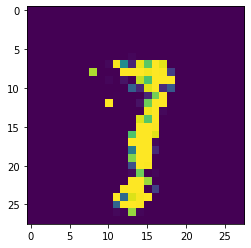

13000/15000 [ 86%] ██████████████████████████     ETA: 97s | Gen Loss: 2.960 | Disc Loss: 0.555 

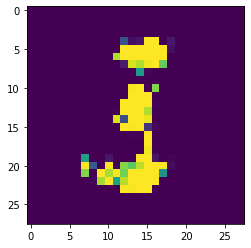

14000/15000 [ 93%] ████████████████████████████   ETA: 45s | Gen Loss: 3.341 | Disc Loss: 0.600

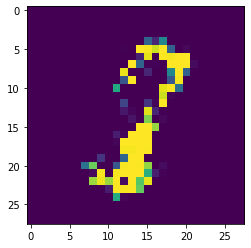

15000/15000 [100%] ██████████████████████████████ Elapsed: 645s | Gen Loss: 2.237 | Disc Loss: 0.652


In [20]:
sess = ed.get_session()
tf.global_variables_initializer().run()

idx = np.random.randint(M, size=16)
i = 0
for t in range(inference.n_iter):
    if t % inference.n_print == 0:
        samples = sess.run(x)
        plt.imshow(samples[1].reshape(28,28))
        plt.show()
        i += 1

    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x_ph: x_batch})
    inference.print_progress(info_dict)